Categories in the Fashion-MNIST

|Label | Class |
|-|-|
|0|	T-shirt/top|
|1|	Trouser|
|2|	Pullover|
|3|	Dress|
|4|	Coat|
|5|	Sandal|
|6|	Shirt|
|7|	Sneaker|
|8|	Bag|
|9|	Ankle boot|
|10| Hat |



In [54]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot', 'Hat']

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms

from PIL import Image
from pylab import rcParams
from typing import cast, Any, Union, Dict, List
import time
import random
import copy 
 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os
import shutil
from collections import OrderedDict

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# See the sample dataset

In [31]:
df = pd.read_csv("Dataset\Deep_Learning_Path.csv",index_col=[0])
train_csv = pd.read_csv(r"DatasetV2\train\Hexacore-Train.csv")
test_csv = pd.read_csv(r"DatasetV2\test\Hexacore-Test.csv")
train_csv_mnist = pd.read_csv(r"Dataset\fashion-mnist_train.csv")
test_csv_mnist = pd.read_csv(r"Dataset\fashion-mnist_test.csv")

In [32]:
print(train_csv.shape)
print(test_csv.shape)

(63400, 785)
(10400, 785)


In [33]:
train_csv

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,0,0,0,0,0,0,0,0,1,...,0,1,0,26,99,86,37,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,109,39,0,0,0,0,0,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,0,1,0,19,121,62,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63395,2,0,0,4,0,0,0,0,0,0,...,0,0,0,0,0,143,232,139,0,0
63396,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
63397,6,0,0,0,0,0,0,0,0,0,...,0,0,0,39,56,18,20,0,0,0
63398,9,0,0,0,0,0,0,0,0,0,...,0,0,6,0,95,119,0,0,0,0


# Dataset
- Build dataset memerlukan inherits dari class `Dataset`
    - `get_item()` return the specified image and it's label
    - `len()` return the number of dataset

In [36]:
class FashionDataset(Dataset):
    def __init__(self, data, transform=None):        
        self.fashion = list(data.values)
        self.transform = transform
        
        label, image = [], []
        
        for i in self.fashion:
            label.append(i[0])
            image.append(i[1:])
        self.labels = np.asarray(label)
        self.images = np.asarray(image).reshape(-1, 28, 28).astype('float32')
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        label = self.labels[idx]
        image = self.images[idx]      
        
        if self.transform is not None:
            # transfrom the numpy array to PIL image before the transform function
            pil_image = Image.fromarray(np.uint8(image)) 
            image = self.transform(pil_image)
            
        return image, label

# Loading Data


In [34]:
## Data Mnist Image folder
train_transform1 = transforms.Compose([
    transforms.RandomChoice([
        transforms.Compose([transforms.RandomVerticalFlip(),transforms.RandomHorizontalFlip()]),
        transforms.Compose([transforms.RandomHorizontalFlip(),transforms.RandomVerticalFlip()])
    ]),
    transforms.RandomAffine(degrees=30,translate=(0.1,0.1)),
    transforms.Resize((70,70)),
    transforms.ToTensor()
    ])

train_transform2 = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.Resize((70,70)),
    transforms.ToTensor()
])

train_transform3 = transforms.Compose([
    transforms.Resize((70,70)),
    transforms.ToTensor()
])

train_transform4 = transforms.Compose([
    transforms.Resize((70,70)),
    transforms.ToTensor(),
    transforms.RandomErasing(p=1, scale=(0.02, 0.2))
])

test_transform = transforms.Compose([
    transforms.Resize((70,70)),
    transforms.ToTensor()
])

In [38]:
# Import data
train_set1 = FashionDataset(train_csv,transform=train_transform1)
train_set2 = FashionDataset(train_csv,transform=train_transform2)
train_set3 = FashionDataset(train_csv,transform=train_transform3)
train_set4 = FashionDataset(train_csv,transform=train_transform4)
train_sets = torch.utils.data.ConcatDataset([train_set1,train_set2,train_set3,train_set4])

test_set = FashionDataset(test_csv,transform=test_transform)
train_set, val_set = torch.utils.data.random_split(train_sets, [int(len(train_sets) * 0.9),int(len(train_sets) * 0.1)])

train_dataloader = torch.utils.data.DataLoader(train_set,
                                               batch_size = 100,
                                               shuffle = True)
val_dataloader = torch.utils.data.DataLoader(val_set,
                                             batch_size=100)

loaders = {
    'train' : train_dataloader,
    'val' : val_dataloader
}

In [44]:
# Before Transformation preprcessing data training
print("Before:",len(train_csv))
print("After:",len(train_csv)*4)
#for metrics
dataset_sizes = { 'train': len(train_set), 'val': len(val_set)}
print(dataset_sizes)

Before: 63400
After: 253600
{'train': 228240, 'val': 25360}


In [46]:
print("Before:",len(test_csv))
#for metrics
print(len(test_set))

Before: 10400
10400


### See Images on Dataset Tranfromation

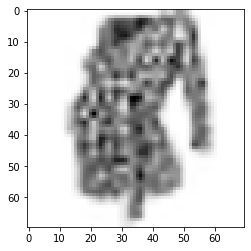

In [63]:
i = np.random.randint(50)
x,y = next(iter(train_dataloader))
plt.imshow(x[i].permute(1,2,0),cmap='Greys')